In [0]:
# Don't run if not running in Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Pre-requisite to install before running the code

In [0]:
from datetime import datetime 
start_real = datetime.now()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydot_ng as pydot
import dask.dataframe as dd
import joblib
from wordcloud import WordCloud
import os
import seaborn as sns
from IPython.display import display

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.corpus import stopwords
import math
# set seed
np.random.seed(123)

### Store the dataset

In [0]:
# Input data files are available in the "../mercari-price-suggestion-challenge/" directory.
# NOTE: Please modify the absolute path before /mercari-price-suggestion-challenge accordingly

# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the mercari-price-suggestion-challenge directory

print(os.listdir("/content/gdrive/My Drive/DMT/mercari-price-suggestion-challenge"))
input_folder = '/content/gdrive/My Drive/DMT/mercari-price-suggestion-challenge/'

# Any results you write to the current directory are saved as output.

['sample_submission.csv.7z', 'sample_submission_stg2.csv', 'train.tsv', 'test.tsv', 'train.pkl', 'wiki.en.bin.bin', 'model.best.weights.hdf5', 'train_word2vec.pkl', 'model.png', 'dumps', 'model_word2vec.best.weights.hdf5', 'val_xgboost.pkl', 'test_xgboost.pkl', 'train_xgboost.pkl']


## 2. Exploratory Data Analysis

In [0]:
train_data_copy = pd.read_pickle(input_folder + 'dumps/whole_data.pkl').drop(labels=['item_condition_id_1', 'item_condition_id_2', 'item_condition_id_3', 'item_condition_id_4', 'item_condition_id_5'], axis=1)

In [0]:
scalar = joblib.load(input_folder + 'dumps/scaler.pkl')
train_data_copy.price = scalar.inverse_transform(train_data_copy.price)

In [0]:
train_data_copy.head()

,train_id,name,item_condition_id,category_name,price,shipping,item_description,item_description_readability_score,desc_len,name_len,cat_1,cat_2,cat_3
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,10.0,1,unk_description,99.00,1,7,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard Razer,3,Electronics/Computers & Tablets/Components & P...,52.0,0,This keyboard is in great condition and works ...,8.13,36,5,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse Target,1,Women/Tops & Blouses/Blouse,10.0,1,Adorable top with a hint of lace and a key hol...,5.80,29,3,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,35.0,1,New with tags. Leather horses. Retail for [rm]...,2.12,32,3,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,44.0,0,Complete with certificate of authenticity,18.00,5,4,Women,Jewelry,Necklaces


CPU times: user 2min 59s, sys: 10.5 s, total: 3min 10s
Wall time: 2min 57s


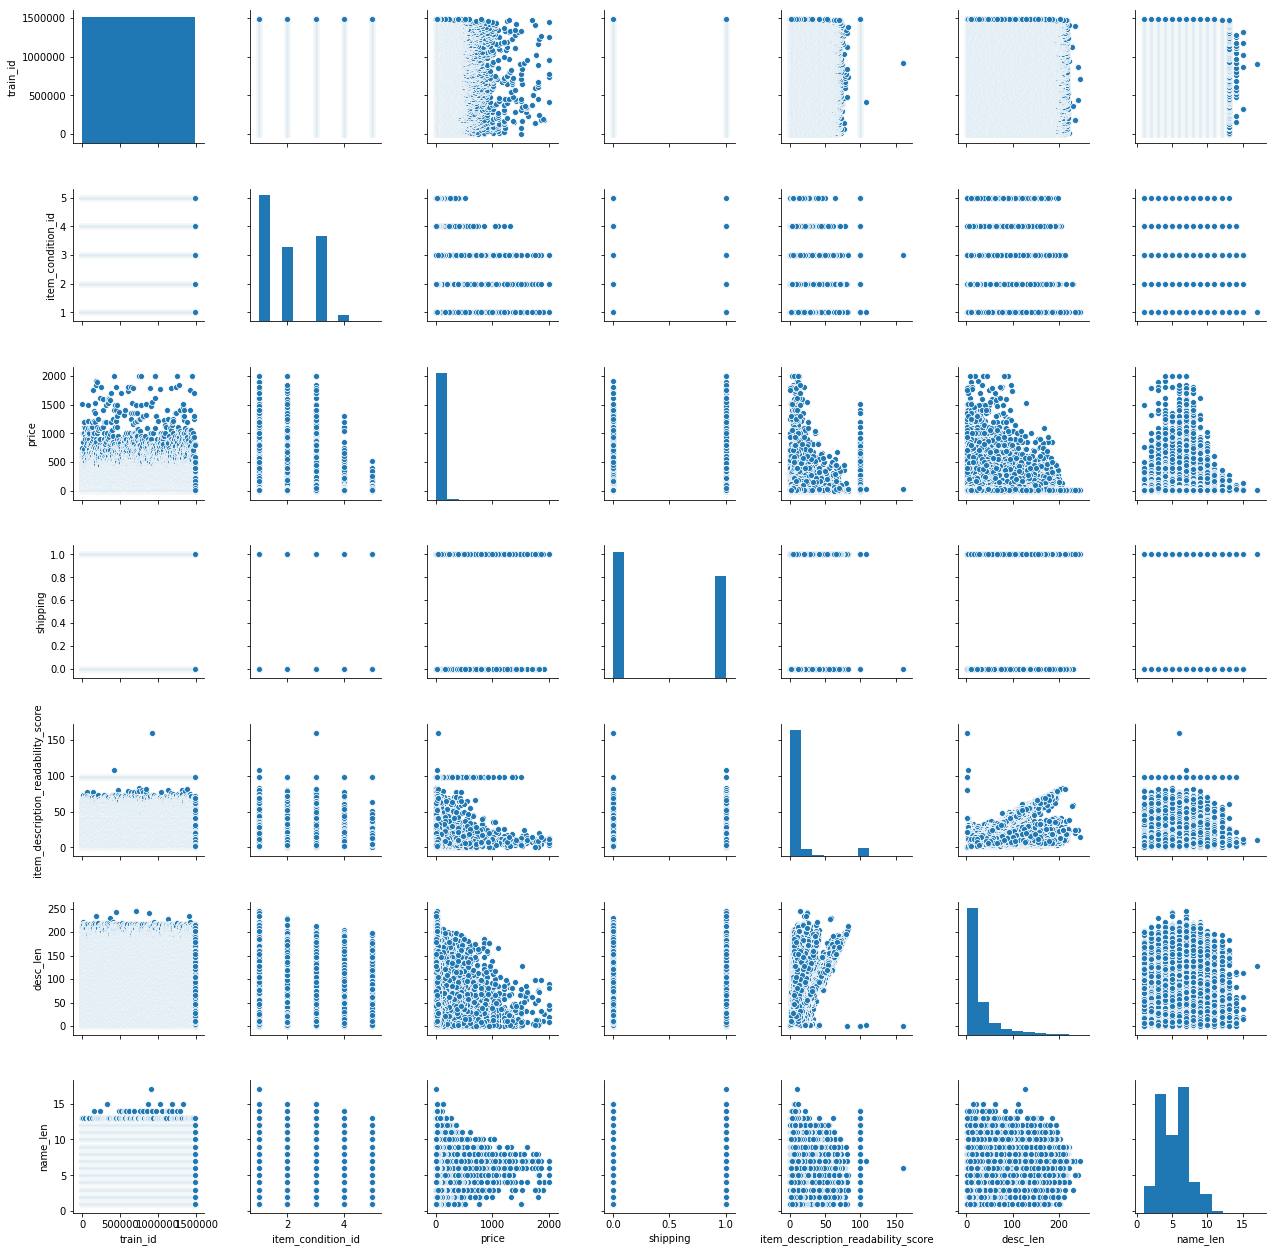

In [0]:
%%time
# Overall graph comparasin of all the features against each other
sns.pairplot(train_data_copy)

In the above pairplots, if we compare the plots of all the attribute with our target variable price, we can the correlation between them. Here are few of the observations:


*   The engineered attribute *item_decription_readability_score*, generated from the attribute *item_description* shows that items are sold for a higher price when the readability score is less. This follows our intution, as lower readability score means that the description is concise and easy to read. 
*   The attribute *desc_len* captures the word counts of *item_description* . Items sold at a higher price have a  lower word count. This may suggest that the buyers prefer a short and concise description and not a long rambling essay describing the item.
*    The attribute *name_len* captures the word counts of *name* attribute (after mergin *name* and *brand_name*). Items sold at a higher price have word counts in the center of the graph. 



### List of Categories to which a product belongs in the dataset




In [0]:
train_data_copy.cat_1.unique()

array(['Men', 'Electronics', 'Women', 'Home', 'Sports & Outdoors',
       'Vintage & Collectibles', 'Beauty', 'Other', 'Kids', 'unk_cat1',
       'Handmade'], dtype=object)

There are 11 Main Categories in the dataset 


*   Men
*   Electronics
*   Women
*   Home
*   Sports & Outdoors
*   Vintage & Collectibles
*   Beauty
*   Other
*   HandMade
*   Women
*   Unspecified Category




### Price Distribution in the Dataset

In [0]:
train_data_copy.price.describe().apply(lambda x: format(x, 'f'))

count    1481658.000000
mean          26.749280
std           38.489080
min            3.000000
25%           10.000000
50%           17.000000
75%           29.000000
max         2000.000000
Name: price, dtype: object

The Price range in the data set starts from 0 to 2009 with the overall averge price the dataset being 26.7

Text(-0.08, 0.5, 'train_id')

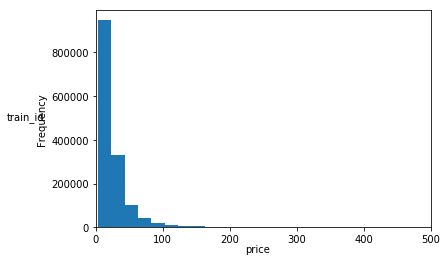

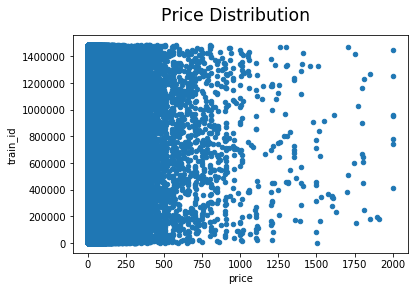

In [0]:
# Visualising the price distribution using graphs 
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
train_data_copy.price.plot(kind='hist', bins=100, xlim=(0,500))
train_data_copy.plot.scatter(x='price',y='train_id')
plt.suptitle('Price Distribution', ha='center', fontsize='xx-large')
fig.text(0.5, 0.04, 'price', ha='center')
fig.text(-0.08, 0.5, 'train_id')

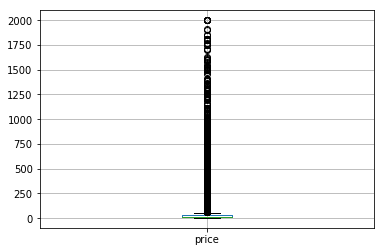

In [0]:
train_data_copy.boxplot(column=['price'])

Majority of the products sell within the 225 dollar scatter plot gives more observable distribution of price in dataset

### Brand Name and Price

In [0]:
# Over 4000 unique brands in the dataset
brand_name_col = pd.read_csv(input_folder + 'train.tsv', sep='\t').brand_name
print("Unique Brands in Data Set :" +  str(brand_name_col.unique().size))
print(brand_name_col.describe())

Unique Brands in Data Set :4810
count     849853
unique      4809
top         PINK
freq       54088
Name: brand_name, dtype: object


In [0]:
# Most popular brands with most items for sale in dataset
brand_info = brand_name_col.value_counts()
bf = pd.DataFrame(brand_info).reset_index()
bf.columns = ['Brand Name', 'count']
display(bf[1:10])

,Brand Name,count
1,Nike,54043
2,Victoria's Secret,48036
3,LuLaRoe,31024
4,Apple,17322
5,FOREVER 21,15186
6,Nintendo,15007
7,Lululemon,14558
8,Michael Kors,13928
9,American Eagle,13254


Text(0, 0.5, 'Avg Selling Price in $')

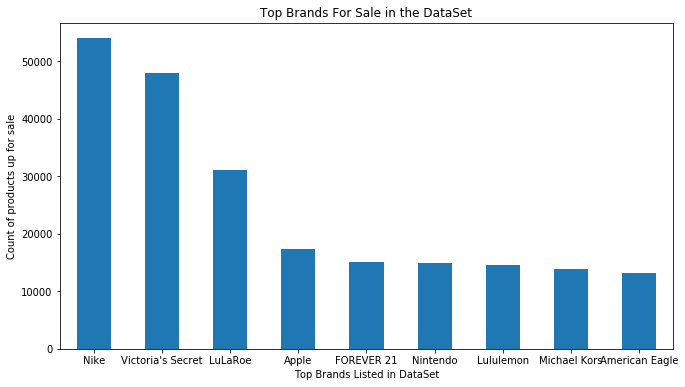

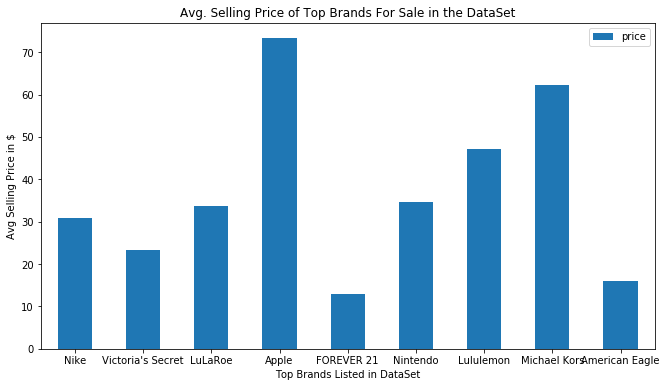

In [0]:
# Plotting a graph for count plot of popular brand and avg selling price of these brands

# Count Plot
ax = brand_info[1:10].plot.bar(y="count" , rot=0,figsize=(11, 6), title="Top Brands For Sale in the DataSet")
ax.set_xlabel("Top Brands Listed in DataSet")
ax.set_ylabel("Count of products up for sale")

# Popular Brand average Selling Price
bi = train_data_copy.pivot_table('price', index=brand_name_col, aggfunc='mean')
brand_info[1:10].tolist()
tb = bi.loc[bf[1:10]['Brand Name']]
ax = tb.plot.bar(y='price', rot=0,figsize=(11, 6),title="Avg. Selling Price of Top Brands For Sale in the DataSet")
ax.set_xlabel("Top Brands Listed in DataSet")
ax.set_ylabel("Avg Selling Price in $")

By Observing the graph for Count plot and Avg Selling Price for top brands we can see that


*   Clothing brands like PINK, Nike, Victoria's Secret etc. have the most products on sale. and since cloths don't cost as muc has electronics or luxury items their product count is high but average selling price is low
*   Electronic brands like Apple, Nintendo have lower product count as compared to clothing brands but have a higher average selling price, this makes sense as electronics products are more expensive then clothing
*  Micheal Kors which is luxury brand, has lower products on sale in the dataset but has a high avg. selling price since luxury brands have a higher selling price



In [0]:
bi = train_data_copy.pivot_table('price', index=brand_name_col, aggfunc='mean')

# Listing brands which have the higest average selling price for a product

bi.sort_values(by=['price'],ascending=False).head()

,price
brand_name,
Demdaco,429.000000
Proenza Schouler,413.250000
Auto Meter,344.000000
Oris,300.000000
MCM Worldwide,289.173913


Text(0, 0.5, 'Avg Selling Price in $')

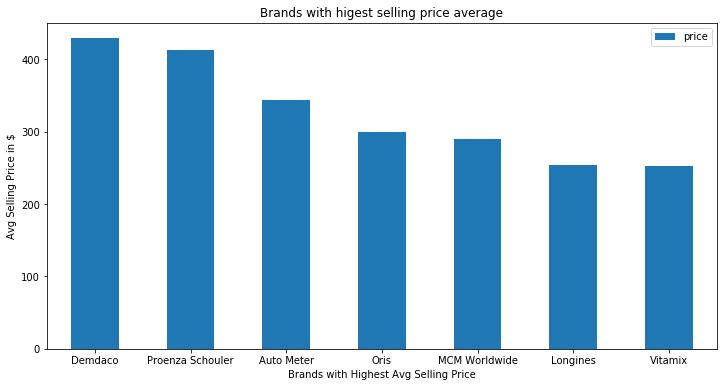

In [0]:
# Plotting graph comparing selling price of products to the most listed (popular) brand in the dataset
ax = bi.sort_values(by=['price'],ascending=False)[0:7].plot.bar(y='price', rot=0,figsize=(12, 6),title="Brands with higest selling price average")
ax.set_xlabel("Brands with Highest Avg Selling Price")
ax.set_ylabel("Avg Selling Price in $")



*   Brands like Demdaco (exclusive range of artist-driven gifts), Proenza Schouler (designer brand) naturally have higher selleing price since they are part of luxury brand and correspondingly their count of products for sale is also less oweing to high price and affodability.





### Main Category and Price 


In [0]:
# Most popular brands with most items for sale in dataset
category_info = train_data_copy["cat_1"].value_counts()
df = pd.DataFrame(category_info).reset_index()
df.columns = ['Category Name', 'count']
display(df[1:10])

,Category Name,count
1,Beauty,207725
2,Kids,171555
3,Electronics,122632
4,Men,93609
5,Home,67831
6,Vintage & Collectibles,46519
7,Other,45329
8,Handmade,30835
9,Sports & Outdoors,25322


Text(0, 0.5, 'AVerage Selling Price')

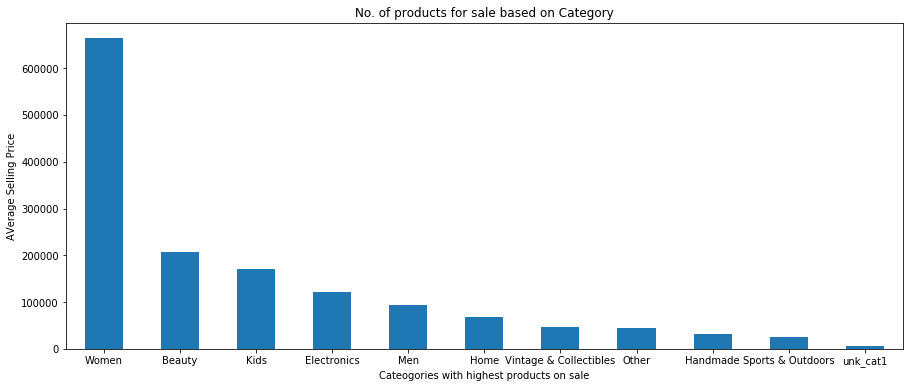

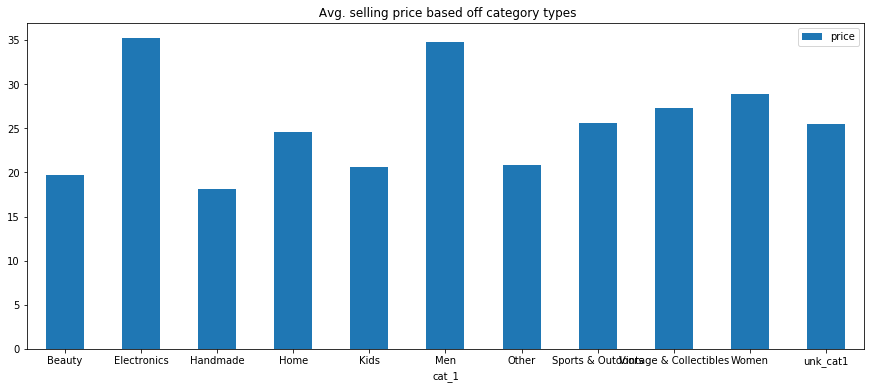

In [0]:
# Count plot of Category Names and their a plot of their average selling price

# Count Plot
ax = category_info.plot.bar(rot=0,figsize=(15, 6),title="No. of products for sale based on Category")
ax.set_xlabel("Cateogories with highest products on sale")
ax.set_ylabel("Number of products for sale")

# Average Selling Price
ci = train_data_copy.pivot_table('price', index='cat_1', aggfunc='mean')
ci.plot.bar(y='price', rot=0,figsize=(15, 6),title=" Avg. selling price based off category types")
ax.set_xlabel("Cateogories with highest products on sale")
ax.set_ylabel("AVerage Selling Price")


From the Count plot and Avg selling price graph plot for Main category from data set it can be observed that
*   Clothing/Shoe/Bags etc. have the highest no. of products on sale (Women, Beauty,Kids,Men) Vategoty. 
*   Categories such as Electronics, Sports and Vintage and Collectibles have lower products on sale but have higher sellnig price as naturally Vintage and Electronics tend to cost more than clothing



### Shipping and Price 

Text(-0.08, 0.5, 'Products')

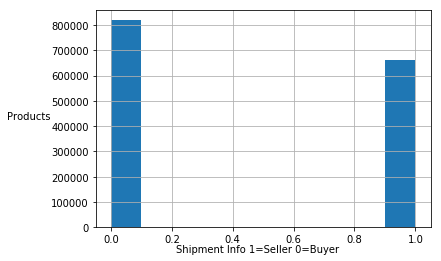

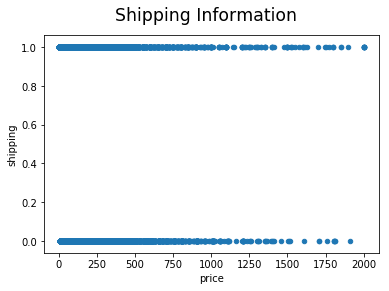

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)

train_data_copy.shipping.hist()
train_data_copy.plot.scatter(x='price',y='shipping')

# Visualising the shipping distribution using graphs 
plt.suptitle('Shipping Information', ha='center', fontsize='xx-large')
fig.text(0.5, 0.04, 'Shipment Info 1=Seller 0=Buyer', ha='center')
fig.text(-0.08, 0.5, 'Products')

From the above graph it can be observed that 


*   There are more items for which the buyer has to pay for shipping (shipping =0) vs compared to when seller pays for the shipping (shipping =1)
*   Avg. Selling price seems to be uniform between the two methods of shipment.



### WORD CLOUD

Let's plot the most important Brand names in a wordcloud.

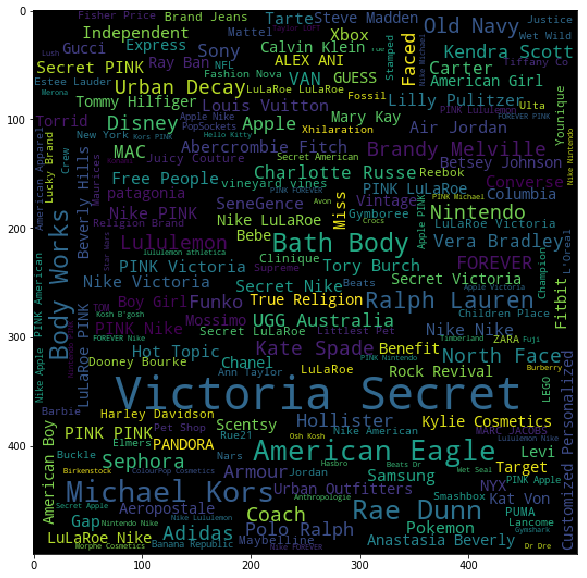

In [0]:
#!pip install wordcloud
wordcloud = WordCloud(width = 500, height = 500).generate(" ".join(brand_name_col[~brand_name_col.isnull()].astype(str)))
plt.figure(figsize = (15, 10))
plt.imshow(wordcloud)
plt.show()

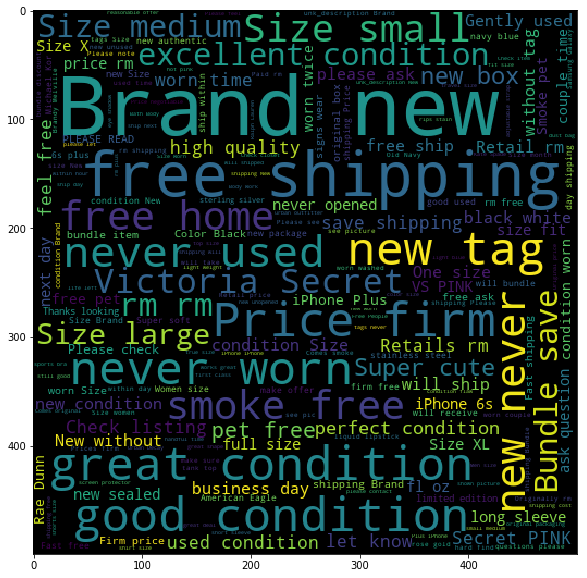

In [0]:
wordcloud = WordCloud(width = 500, height = 500).generate(" ".join(train_data_copy.item_description.astype(str)))
plt.figure(figsize = (15, 10))
plt.imshow(wordcloud)
plt.show()

### Use Linear Regression and HeatMap for Feature Correlation : Analysis the correlation between Dependent variable (Price) and independent variables

In [0]:
# Function to convert string to numeric value (Can be useful for regression Model)
def toNumeric(data,to):
    if train_data_copy[data].dtype == type(object):
        le = LabelEncoder()
        train_data_copy[to] = le.fit_transform(train_data_copy[data].astype(str)) 

In [0]:
toNumeric('name','num_name')
toNumeric('category_name','num_category_name')
toNumeric('cat_1','num_cat_1')
toNumeric('cat_2','num_cat_2')
toNumeric('cat_3','num_cat_3')
train_data_copy.head()

,train_id,name,item_condition_id,category_name,price,shipping,item_description,item_description_readability_score,desc_len,name_len,cat_1,cat_2,cat_3,num_name,num_category_name,num_cat_1,num_cat_2,num_cat_3
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,10.0,1,unk_description,99.00,1,7,Men,Tops,T-shirts,662472,808,5,102,762
1,1,Razer BlackWidow Chroma Keyboard Razer,3,Electronics/Computers & Tablets/Components & P...,52.0,0,This keyboard is in great condition and works ...,8.13,36,5,Electronics,Computers & Tablets,Components & Parts,932924,86,1,30,212
2,2,AVA-VIV Blouse Target,1,Women/Tops & Blouses/Blouse,10.0,1,Adorable top with a hint of lace and a key hol...,5.80,29,3,Women,Tops & Blouses,Blouse,92303,1254,9,103,94
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,35.0,1,New with tags. Leather horses. Retail for [rm]...,2.12,32,3,Home,Home Décor,Home Décor Accents,579460,485,3,55,404
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,44.0,0,Complete with certificate of authenticity,18.00,5,4,Women,Jewelry,Necklaces,45768,1181,9,58,536


Text(0.5, 0.98, ' Correlations Heat Map for attributes')

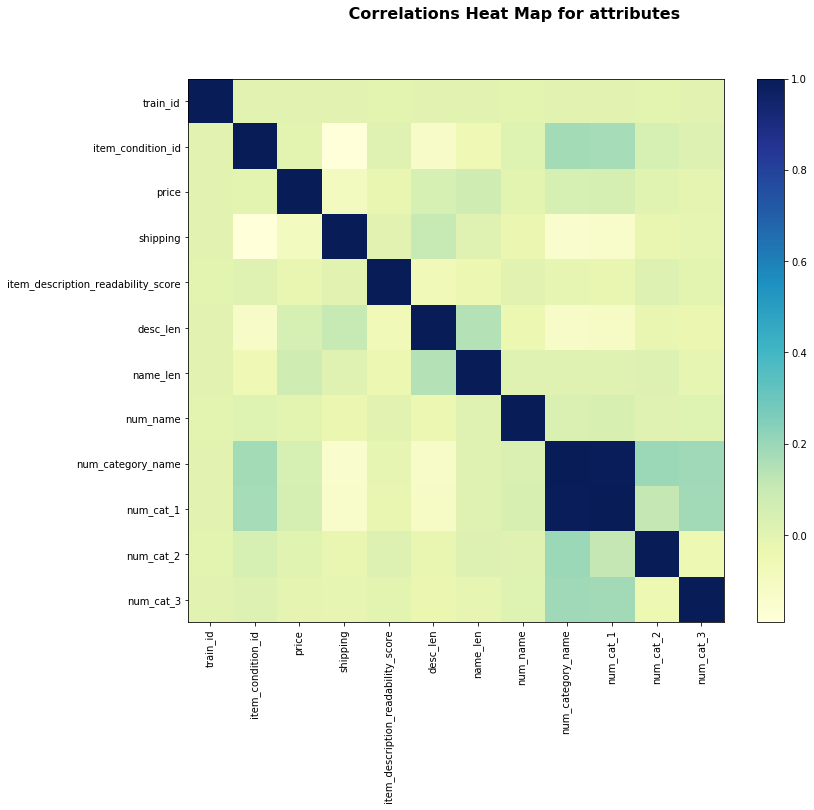

In [0]:
corltn=train_data_copy.corr()
corltn=corltn.fillna(0)
plt.figure(figsize=(12, 10))
plt.imshow(corltn, cmap='YlGnBu', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corltn)), corltn.columns, rotation='vertical')
plt.yticks(range(len(corltn)), corltn.columns);
plt.suptitle(' Correlations Heat Map for attributes', fontsize=16, fontweight='bold')

In [0]:
cats = train_data_copy['cat_1'].value_counts().index.values.astype('str')
display(cats)

array(['Women', 'Beauty', 'Kids', 'Electronics', 'Men', 'Home',
       'Vintage & Collectibles', 'Other', 'Handmade', 'Sports & Outdoors',
       'unk_cat1'], dtype='<U22')

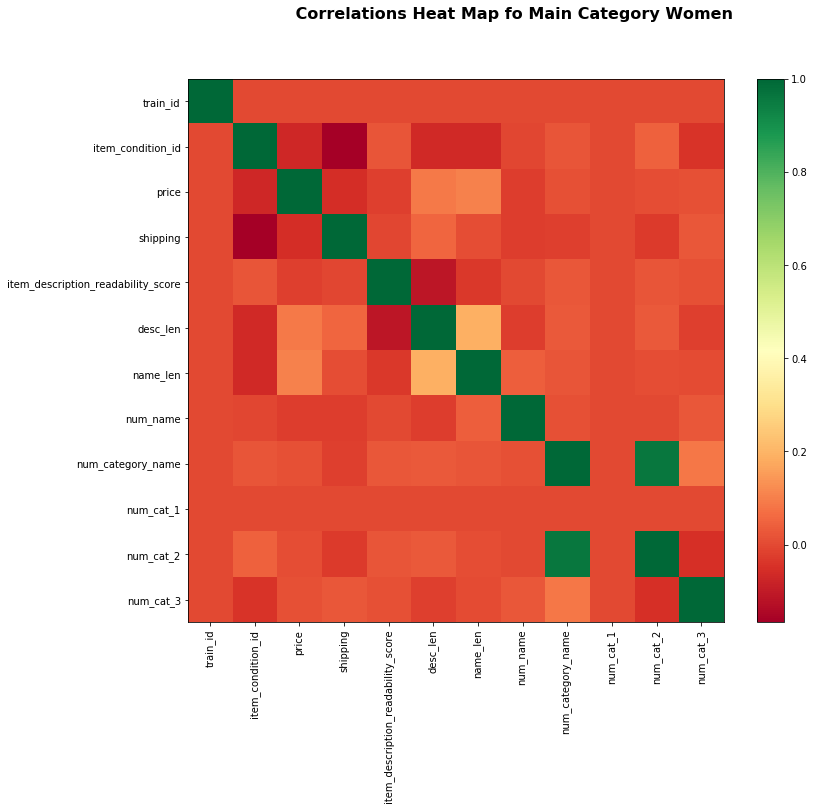

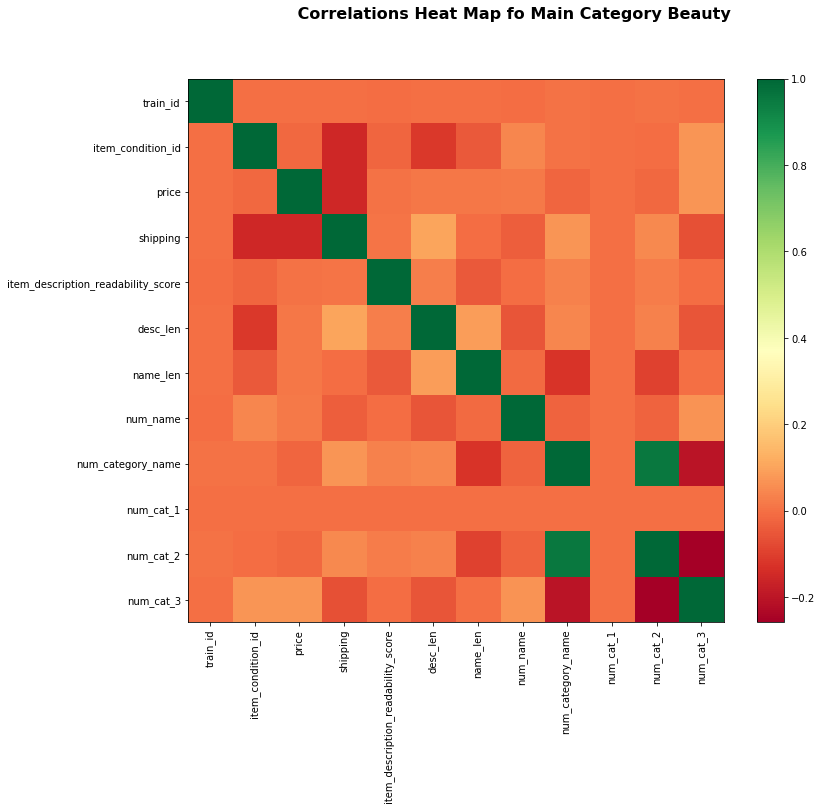

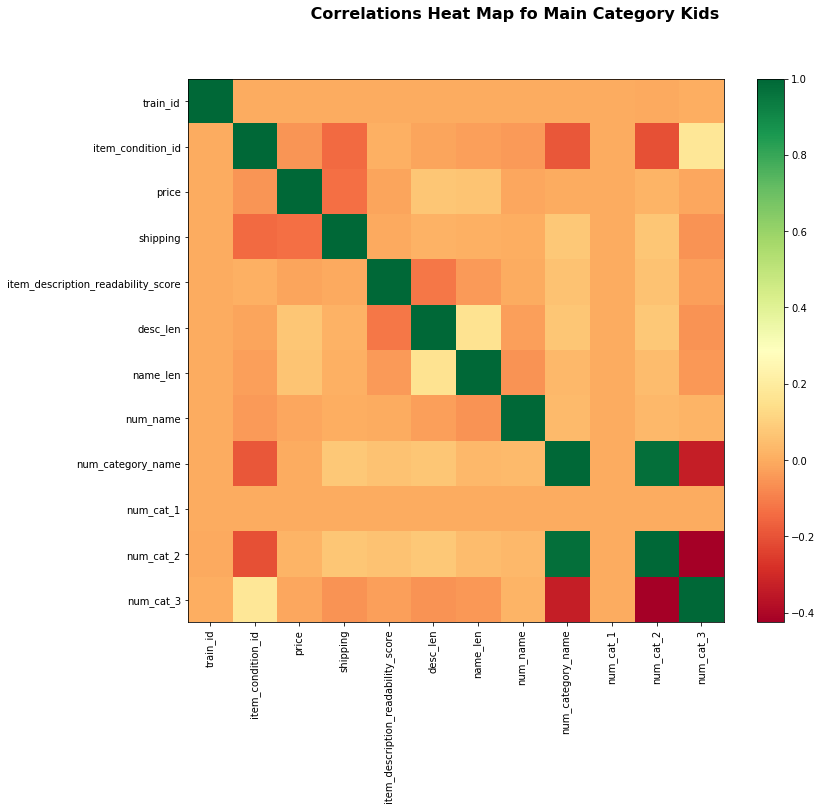

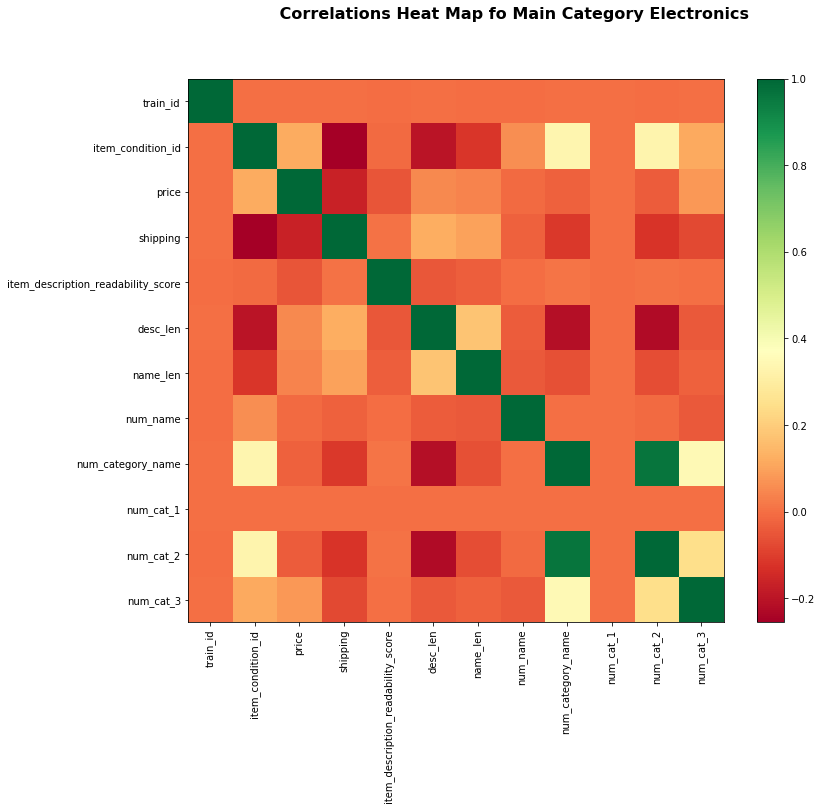

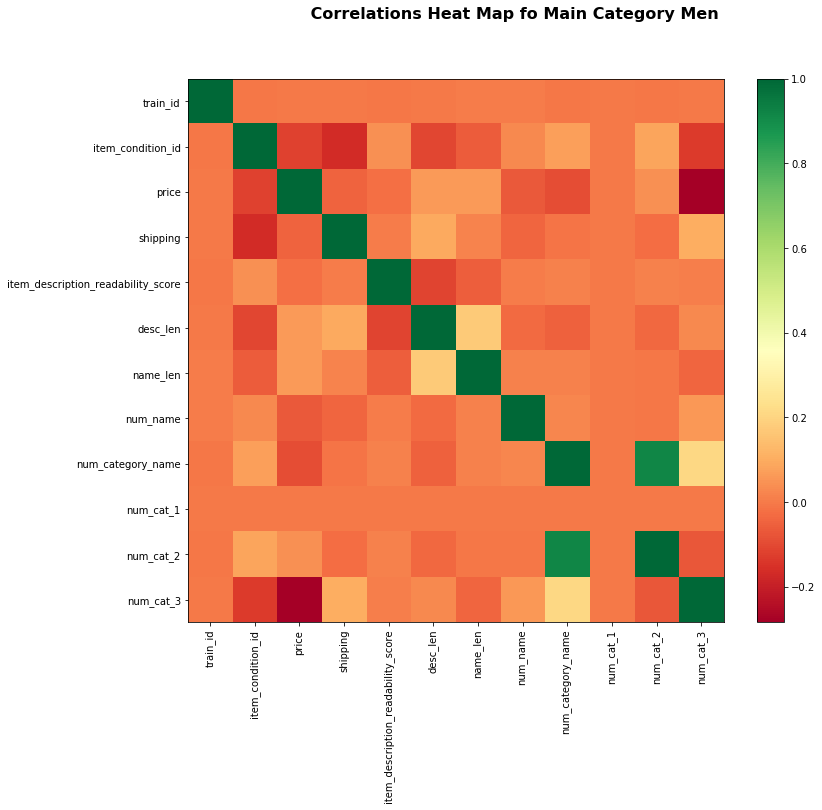

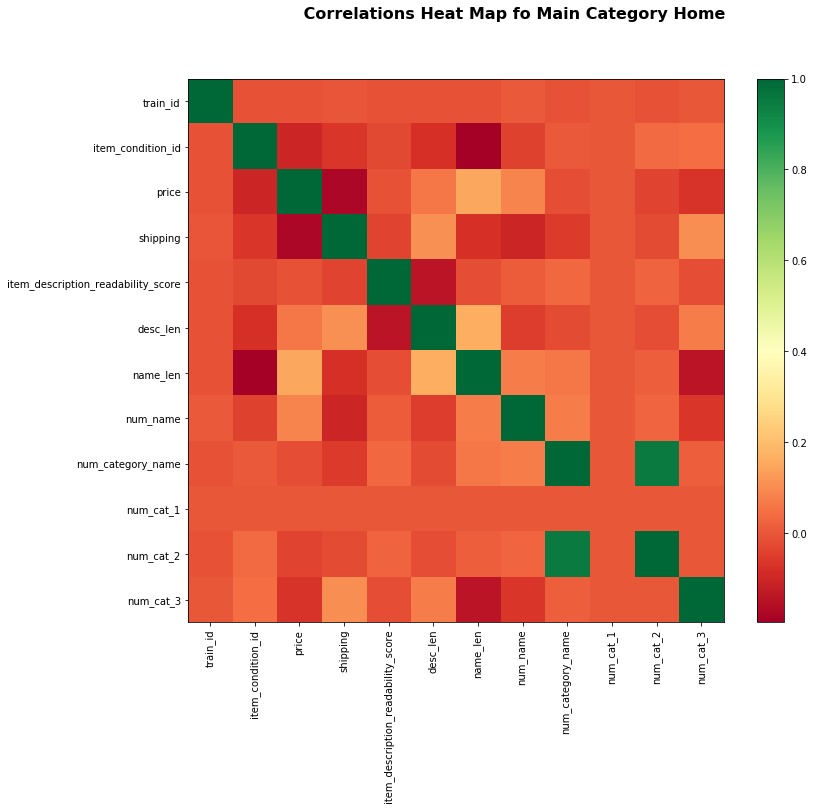

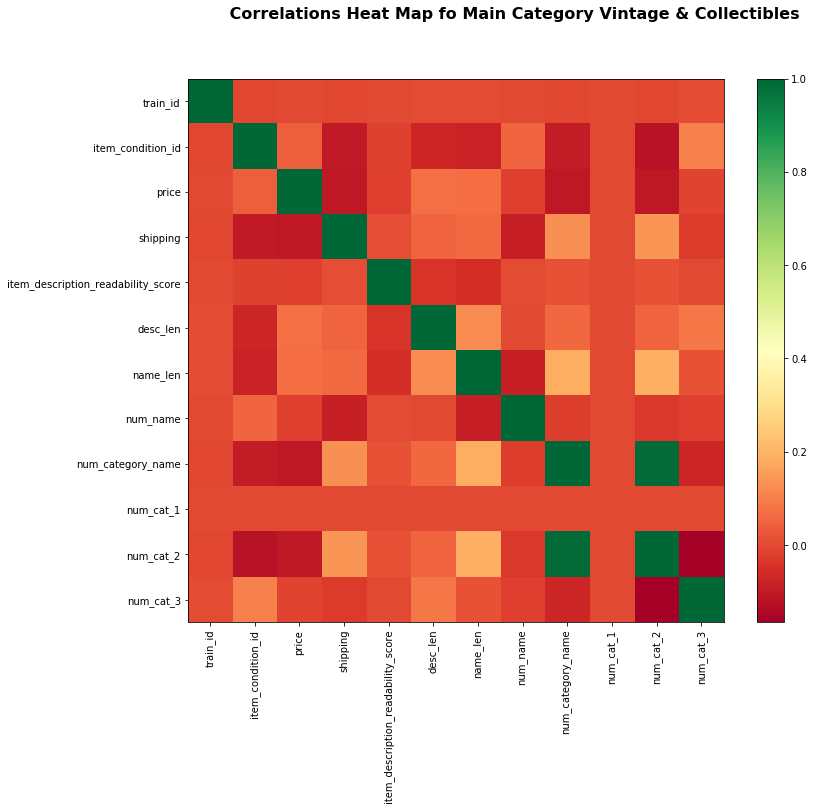

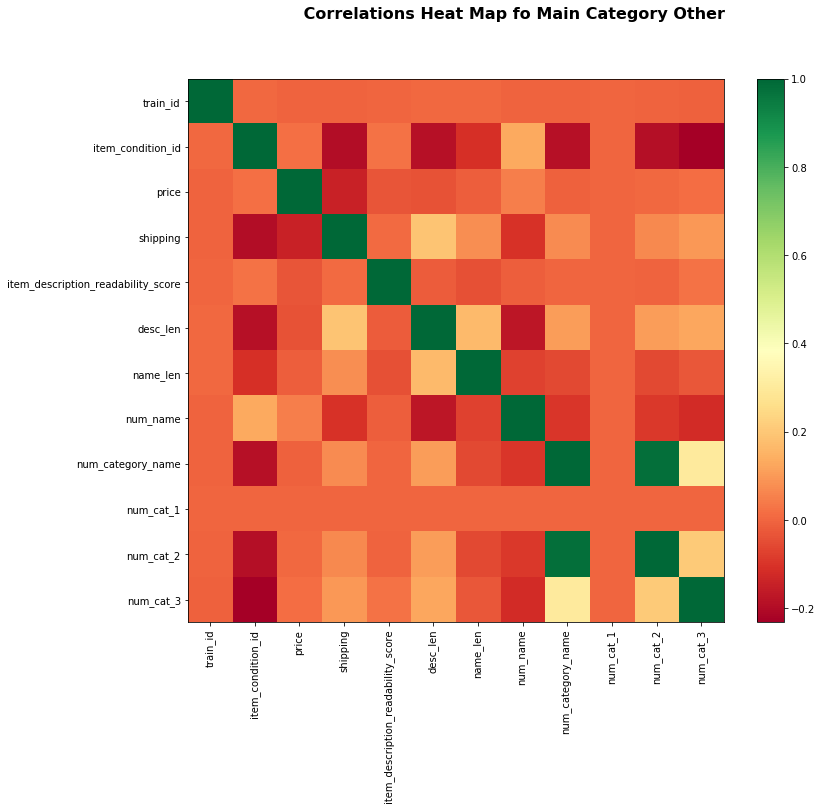

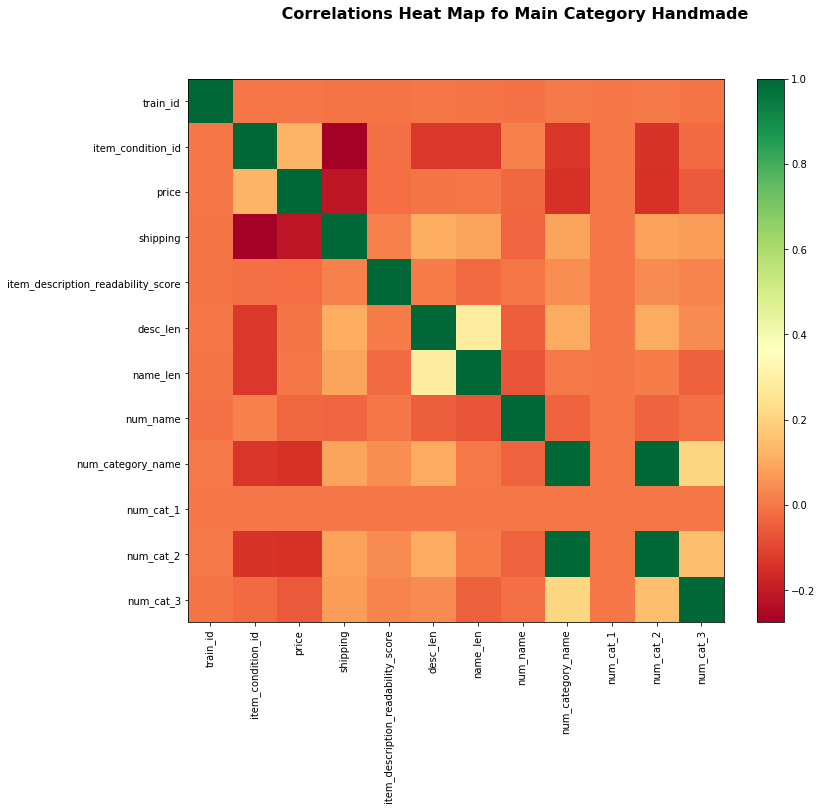

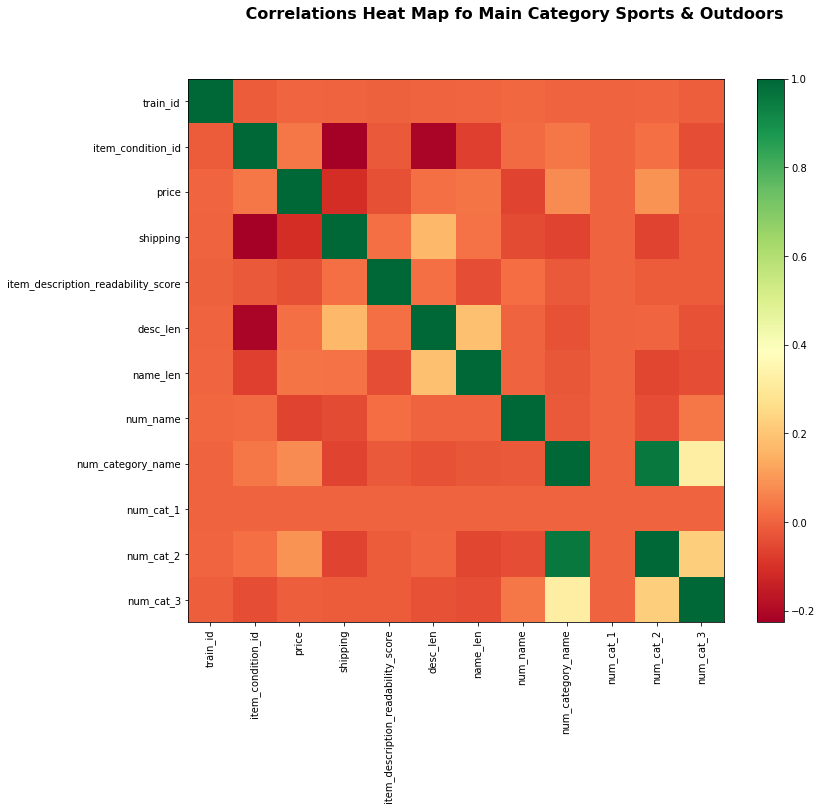

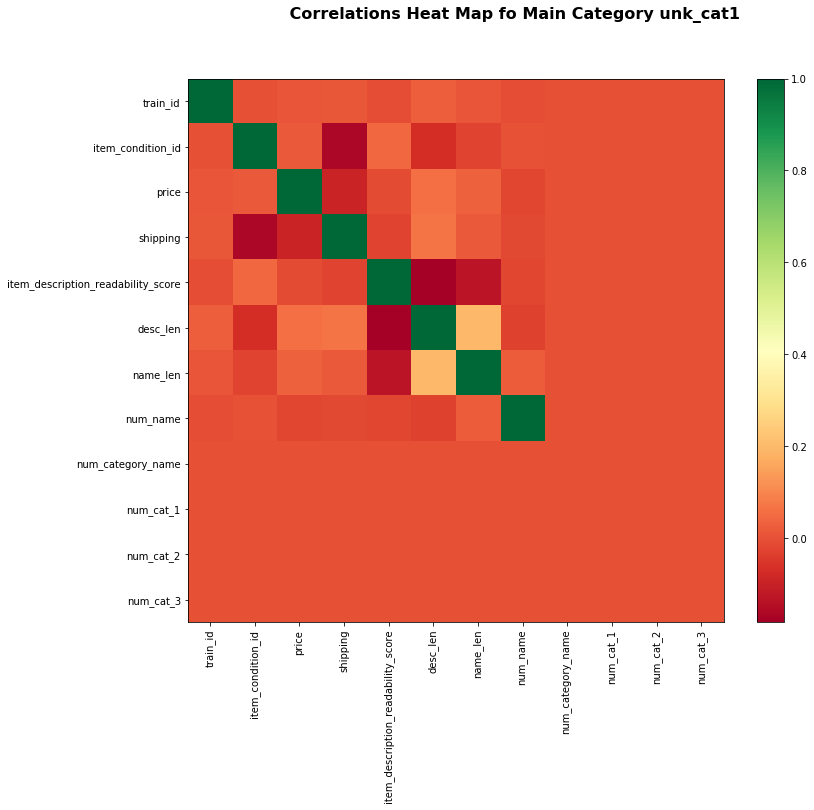

In [0]:
for data in cats:
    gtrain_cat=train_data_copy.loc[train_data_copy['cat_1'] == data]
    corltn=gtrain_cat.corr()
    corltn=corltn.fillna(0)
    plt.figure(figsize=(12, 10))
    plt.imshow(corltn, cmap='RdYlGn', interpolation='none', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(corltn)), corltn.columns, rotation='vertical')
    plt.yticks(range(len(corltn)), corltn.columns);
    plt.suptitle(' Correlations Heat Map fo Main Category '+ data, fontsize=16, fontweight='bold')
    plt.show()

### Plot word2vec vectors 

Here, we will plot the word2vec vetors extracted for the columns *name*  and *item_description* with respect to the target variable *price*.  These graphs may not accurately capture the intricacies of 100 dimensional word vectore as we are only taking the sum of those 100 vectores.

In [0]:
# Load the processed word vectors from saved pickle file
train_data_w2v = pd.read_pickle(input_folder + 'dumps/whole_data_word2vec.pkl')
cols = pd.io.parsers.ParserBase({'names':train_data_w2v.columns})._maybe_dedup_names(train_data_w2v.columns)
train_data_w2v.columns = cols
train_data_w2v.drop(['train_id', 'item_condition_id', 'category_name', 'price', 
                     'shipping', 'item_description_readability_score',
                     'desc_len', 'name_len', 'cat_1', 'cat_2', 'cat_3', 'name', 
                     'item_description'], axis=1, inplace=True)

In [0]:
# Get the first 100 columns that represent the attribute name
name_w2v = train_data_w2v.iloc[:, :100]

No handles with labels found to put in legend.


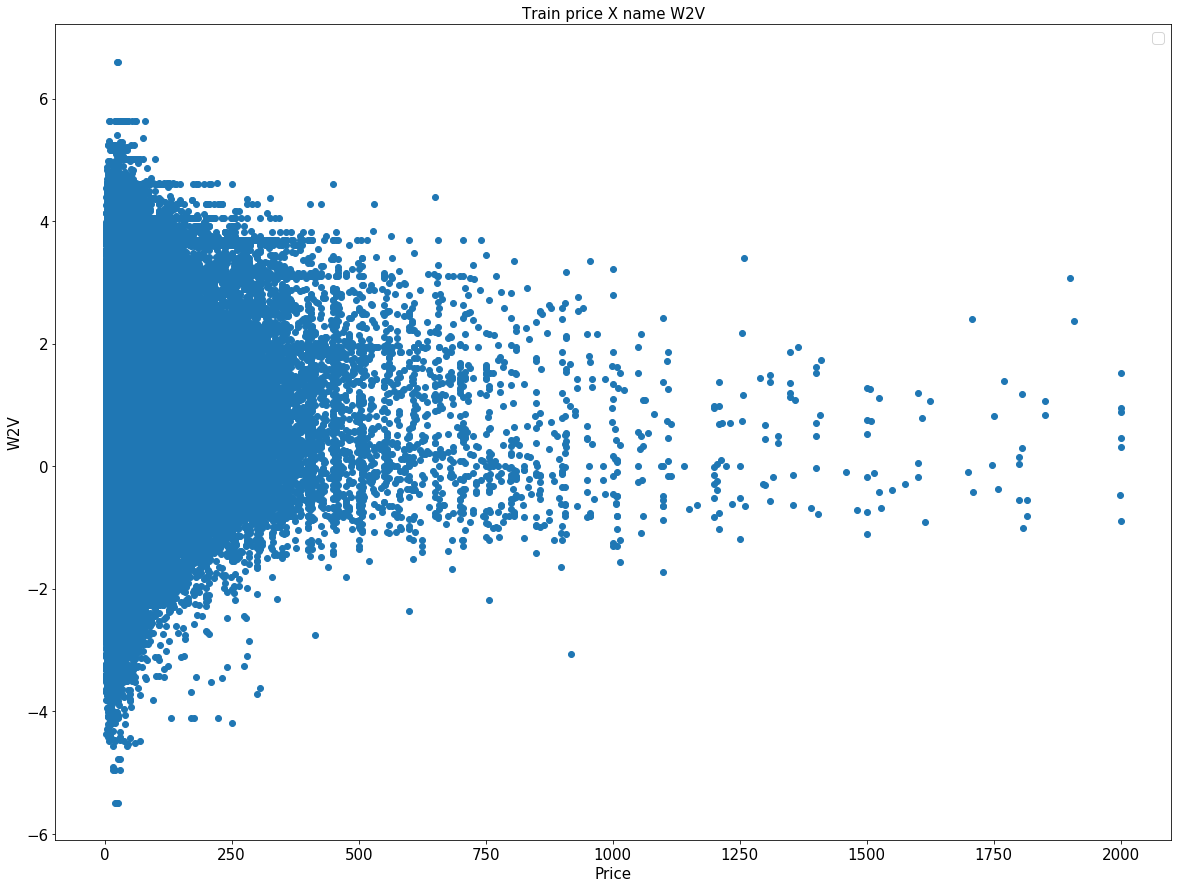

In [0]:
plt.figure(figsize=(20, 15))
plt.scatter(train_data_copy['price'], name_w2v.sum(axis=1))
plt.title('Train price X name W2V', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('W2V', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

We see a slight coorelation between the two variables. More items have a higher price where the sum of word2vec vector is more.

In [0]:
# Get the last 100 columns that represent the attribute item_description
desc_w2v = train_data_w2v.iloc[:, 100:]

No handles with labels found to put in legend.


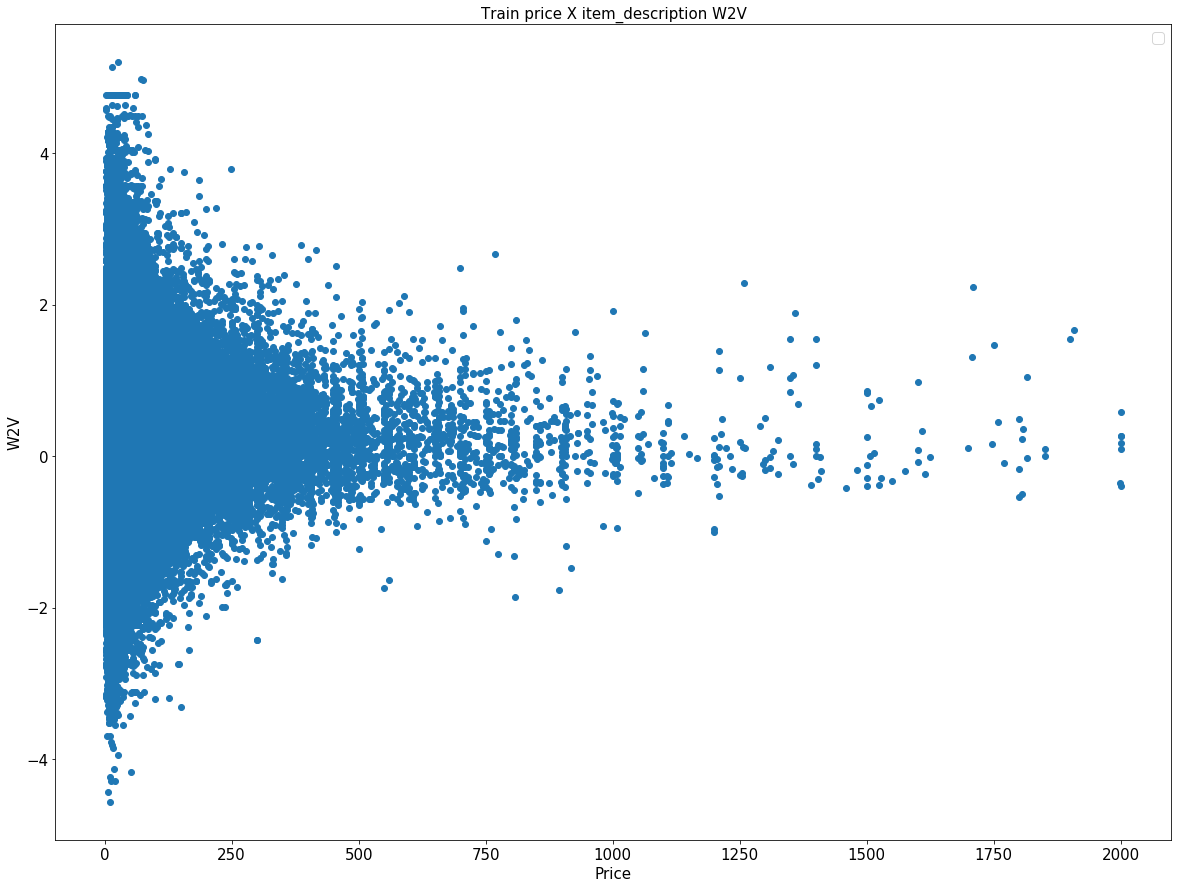

In [0]:
plt.figure(figsize=(20, 15))
plt.scatter(train_data_copy['price'], desc_w2v.sum(axis=1))
plt.title('Train price X item_description W2V', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('W2V', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

We do not see much coorelation between the two variables.

### Word Count x Price

Here, we will plot the word counts extracted for the columns *name*  and *item_description* with respect to the target variable *price*

In [0]:
train_data_len = pd.read_pickle(input_folder + 'dumps/whole_data_word2vec.pkl')[['desc_len', 'name_len']]

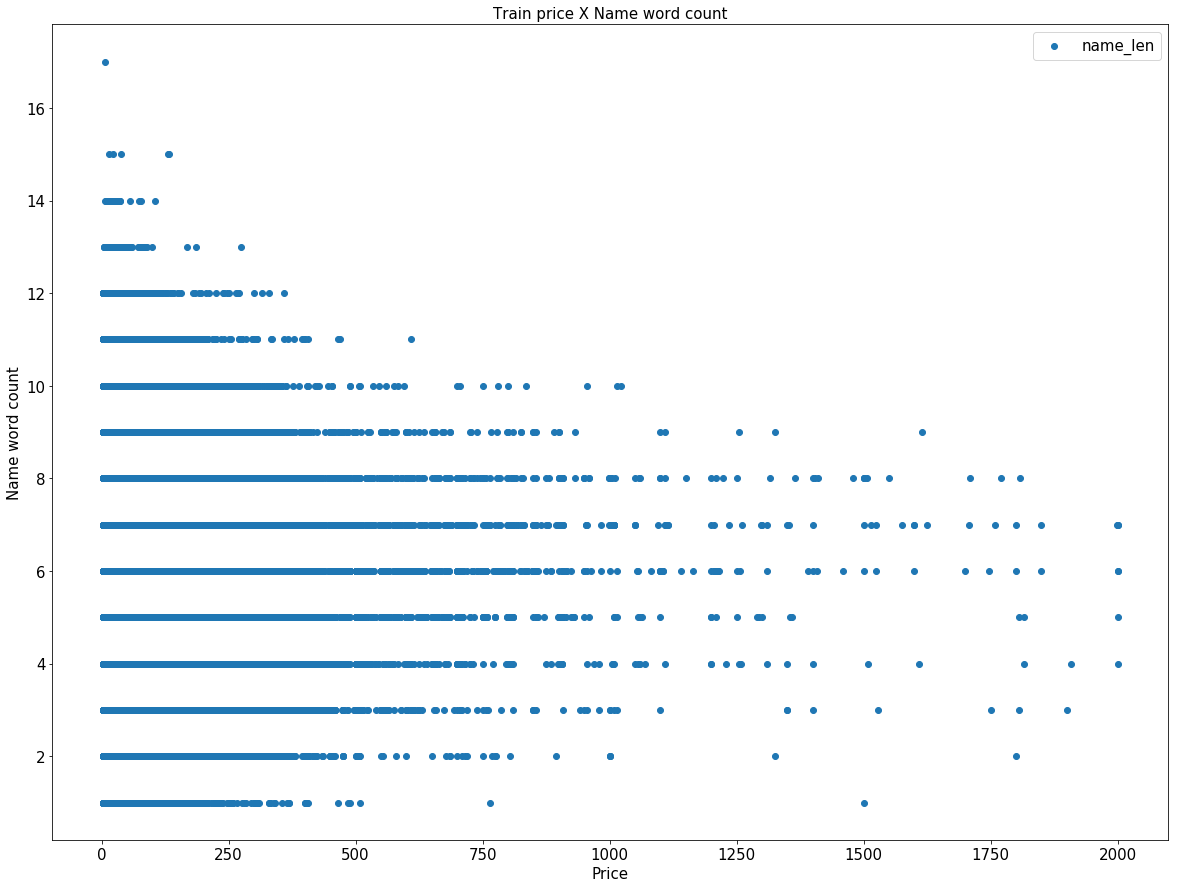

In [0]:
plt.figure(figsize=(20, 15))
plt.scatter(train_data_copy['price'], train_data_len.name_len)
plt.title('Train price X Name word count', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('Name word count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

We can see that the price of item is highest when the word count is between the range of 3 to 9.

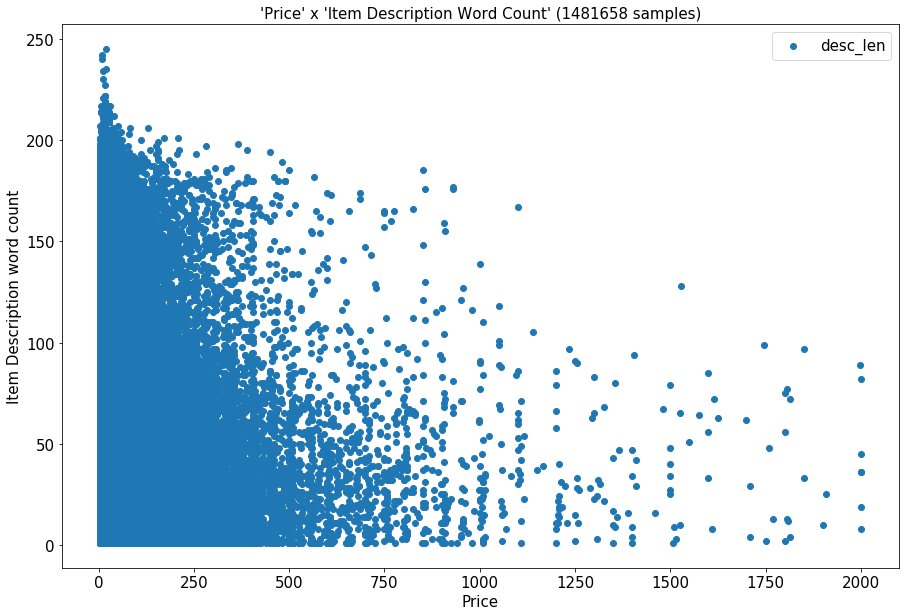

In [0]:
plt.figure(figsize=(15, 10))
plt.scatter(train_data_copy['price'], train_data_len.desc_len)
plt.title("'Price' x 'Item Description Word Count' ({} samples)".format(train_data_len.shape[0]), fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('Item Description word count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

We can see that items sold at a higher price have 100 or less words in their description. 

We had replaced *NaN* values and '*No Description Yet*' texts with '*unk_description*' tokens. Let us remove and see if it affects our graph.

In [0]:
# Get the indices where item_description is not 'unk_description'
no_unk_index = train_data_copy[train_data_copy.item_description != 'unk_description'].index.tolist()

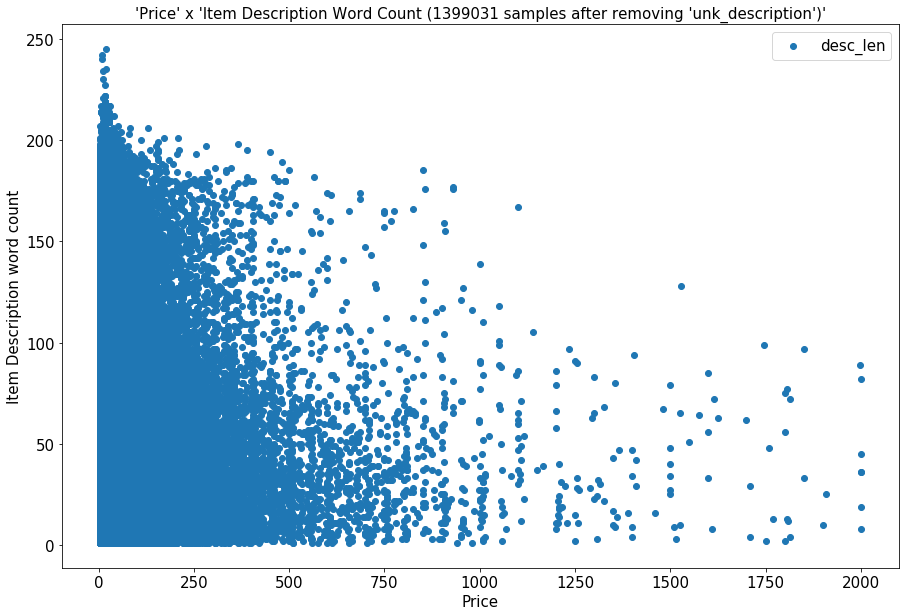

In [0]:
plt.figure(figsize=(15, 10))
plt.scatter(train_data_copy['price'][no_unk_index], train_data_len.desc_len[no_unk_index])
plt.title("'Price' x 'Item Description Word Count ({} samples after removing 'unk_description')'".format(len(no_unk_index)), fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('Item Description word count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

Even after removing samples containing ‘unk_description’ that has word count 1, we can see the correlation does not get affected.